In [1]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
train_data = datasets.MNIST(
    root='data',  # where to download?
    train=True,  # do we want the train/test datasets?
    download=True,
    transform=ToTensor(),  # how to transform the data
    target_transform=None  # how to transform the target
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 50
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [5]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([50, 1, 28, 28]), torch.Size([50]))

In [6]:
# device diagnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# build model
class DigitModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=16):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

torch.manual_seed(RANDOM_SEED)
# input has size [33600, 784], meaning we have 33600 images with size [784], matches input_features
# every image is converted to a vector with 10 entries, thus the input is converted to a [33600, 10] matrix
model = DigitModel(input_features=784,
                   output_features=10,
                   hidden_units=16).to(device)

model
# model(train_features_batch.reshape([32, 1, 784]).to(device))

DigitModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [7]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

# evaluation metric
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()  # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [9]:
epochs = 6

for epoch in range(epochs):
    print(f"Epoch: {epoch}")

    train_loss = 0
    model.train()
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        y_preds = model(X_train.reshape([50, 784]))

        loss = loss_fn(y_preds, y_train)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(test_dataloader):
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_preds = model(X_test.reshape([50, 784]))

            test_loss += loss_fn(test_preds, y_test)

            test_acc += accuracy_fn(y_true=y_test,
                                    y_pred=test_preds.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.3f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.3f}")
        print("----------")

Epoch: 0
Train loss: 0.178 | Test loss: 0.164 | Test acc: 94.840
----------
Epoch: 1
Train loss: 0.166 | Test loss: 0.164 | Test acc: 94.980
----------
Epoch: 2
Train loss: 0.157 | Test loss: 0.169 | Test acc: 94.700
----------
Epoch: 3
Train loss: 0.146 | Test loss: 0.161 | Test acc: 95.070
----------
Epoch: 4
Train loss: 0.141 | Test loss: 0.157 | Test acc: 95.090
----------
Epoch: 5
Train loss: 0.136 | Test loss: 0.190 | Test acc: 94.060
----------


In [9]:
all_data = []
all_labels = []

for data, labels in test_dataloader:
    all_data.append(data)
    all_labels.append(labels)

all_data = torch.cat(all_data, dim=0)
all_labels = torch.cat(all_labels, dim=0)

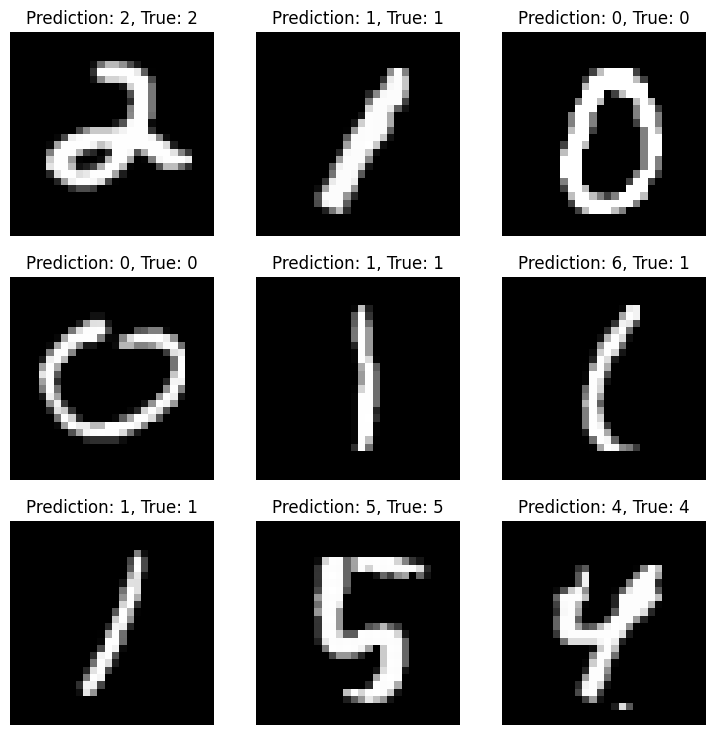

In [13]:
import random

plt.figure(figsize=(9, 9))
for i in range(9):
    idx = random.randint(0, len(all_data))
    test_imag = all_data[idx]
    test_label = model(test_imag.reshape([784]).to(device)).argmax()
    true_label = all_labels[idx]

    plt.subplot(3, 3, i+1)
    plt.gray()
    plt.imshow(test_imag.squeeze())
    plt.title(f"Prediction: {test_label}, True: {true_label}")
    plt.axis(False)